# Voice recognition project 20 Features

## Extraction of features

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle

BASE_DIR = os.path.dirname(os.path.abspath("__file__"))  
TRAIN_AUDIO_PATH = os.path.join(BASE_DIR, "train", "train", "audio")
TEST_AUDIO_PATH = os.path.join(BASE_DIR, "test", "test", "audio")
VALIDATION_LIST_PATH = os.path.join(BASE_DIR, "train", "train", "validation_list.txt")
TESTING_LIST_PATH = os.path.join(BASE_DIR, "train", "train", "testing_list.txt")
OUTPUT_FILE = os.path.join(BASE_DIR, "Pickel", "pca_preprocessed_data.pkl")

SAMPLING_RATE = 16000
N_MFCC = 13
PCA_COMPONENTS = 20  

def load_file_list(file_path):
    with open(file_path, "r") as f:
        return set(line.strip() for line in f)

validation_files = load_file_list(VALIDATION_LIST_PATH)
testing_files = load_file_list(TESTING_LIST_PATH)

def preprocess_audio(file_path, sr=SAMPLING_RATE, n_mfcc=N_MFCC, target_frames=50):
    try:
        y, _ = librosa.load(file_path, sr=sr)
        y = librosa.util.normalize(y)
        
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        delta = librosa.feature.delta(mfcc)
        delta_delta = librosa.feature.delta(mfcc, order=2)
        
        features = np.concatenate([mfcc, delta, delta_delta], axis=0)
        
        if features.shape[1] < target_frames:
            padding = target_frames - features.shape[1]
            features = np.pad(features, ((0, 0), (0, padding)), mode='constant')
        elif features.shape[1] > target_frames:
            features = features[:, :target_frames]
        
        flattened_features = features.flatten()
        
        return flattened_features
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None


def fit_pca(dataset):
    all_features = np.vstack(dataset["features"].to_numpy())
    
    scaler = StandardScaler()
    standardized_features = scaler.fit_transform(all_features)
    
    pca = PCA(n_components=PCA_COMPONENTS)
    reduced_features = pca.fit_transform(standardized_features)
    
    return reduced_features, scaler, pca

def transform_with_pca(features, scaler, pca):
    standardized_features = scaler.transform(features.reshape(1, -1))
    return pca.transform(standardized_features).flatten()

def process_dataset(audio_path, validation_files, testing_files):
    dataset = []
    for label in tqdm(os.listdir(audio_path), desc="Processing Labels"):
        label_dir = os.path.join(audio_path, label)
        if not os.path.isdir(label_dir):
            continue

        for file_name in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file_name)
            if not file_path.endswith(".wav"):
                continue

            relative_path = f"{label}/{file_name}"

            subset = "train"
            if relative_path in validation_files:
                subset = "validation"
            elif relative_path in testing_files:
                subset = "test"

            features = preprocess_audio(file_path, SAMPLING_RATE, N_MFCC)
            if features is not None:
                dataset.append({
                    "filename": file_name,
                    "label": label,
                    "subset": subset,
                    "features": features
                })

    return pd.DataFrame(dataset)

print("Processing training dataset...")
train_df = process_dataset(TRAIN_AUDIO_PATH, validation_files, testing_files)

validation_df = train_df[train_df["subset"] == "validation"]
train_df = train_df[train_df["subset"] == "train"]

print("Fitting PCA on training features...")
train_features, scaler, pca = fit_pca(train_df)

train_df["features"] = [transform_with_pca(f, scaler, pca) for f in train_df["features"].to_numpy()]

print("Transforming validation features with PCA...")
validation_df["features"] = [transform_with_pca(f, scaler, pca) for f in validation_df["features"].to_numpy()]

print("Processing testing dataset...")
test_files = [f for f in os.listdir(TEST_AUDIO_PATH) if f.endswith(".wav")]
test_data = []
for file_name in tqdm(test_files, desc="Processing Test Files"):
    file_path = os.path.join(TEST_AUDIO_PATH, file_name)
    features = preprocess_audio(file_path, SAMPLING_RATE, N_MFCC)
    if features is not None:
        reduced_features = transform_with_pca(features, scaler, pca)
        test_data.append({
            "filename": file_name,
            "features": reduced_features
        })
test_df = pd.DataFrame(test_data)

os.makedirs(os.path.dirname(OUTPUT_FILE), exist_ok=True)  
with open(OUTPUT_FILE, "wb") as f:
    pickle.dump({"train": train_df, "validation": validation_df, "test": test_df}, f)

print(f"Preprocessing complete with PCA applied! Data saved to {OUTPUT_FILE}")

# Creation of train, test and validation set

In [1]:
import pickle

pickle_file_path = r"tensorflow-speech-recognition-challenge\Pickel\pca_preprocessed_data.pkl"

with open(pickle_file_path, "rb") as f:
    data = pickle.load(f)

train_df = data.get("train")
validation_df = data.get("validation")
test_df = data.get("test")

print("Train Data (First 5 Rows):")
print(train_df.head() if train_df is not None else "Train data not found.")

print("\nValidation Data (First 5 Rows):")
print(validation_df.head() if validation_df is not None else "Validation data not found.")

print("\nTest Data (First 5 Rows):")
print(test_df.head() if test_df is not None else "Test data not found.")



Train Data (First 5 Rows):
                filename label subset  \
0  00176480_nohash_0.wav   bed  train   
1  004ae714_nohash_0.wav   bed  train   
2  004ae714_nohash_1.wav   bed  train   
3  00f0204f_nohash_0.wav   bed  train   
4  00f0204f_nohash_1.wav   bed  train   

                                            features  
0  [-0.08795728, -0.08357312, -0.14269097, -0.030...  
1  [-0.06988704, -0.053796638, -0.018251393, 0.04...  
2  [-0.0714234, -0.04462205, -0.017229583, 0.0355...  
3  [-0.10407354, -0.07885466, -0.097180784, 0.000...  
4  [-0.09794326, -0.07037194, -0.078883305, 0.016...  

Validation Data (First 5 Rows):
                 filename label      subset  \
18  026290a7_nohash_0.wav   bed  validation   
35  060cd039_nohash_0.wav   bed  validation   
36  060cd039_nohash_1.wav   bed  validation   
45  099d52ad_nohash_0.wav   bed  validation   
66  0e17f595_nohash_0.wav   bed  validation   

                                             features  
18  [-0.085139796, -0.05

## Visualization of a sample

In [64]:
import numpy as np

X = np.array(train_df["features"].tolist()) 
y = np.array(train_df["label"]) 

list_of_labels = np.unique(y).tolist()

print("List of labels before proccesing:  ", list_of_labels,"\n")

important_labels = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "_background_noise_"]

y = np.array([label if label in important_labels else "unknown" for label in y])
y = np.array(["silence" if label == "_background_noise_" else label for label in y])

print("Example of a sample: \n")
print(X[0], "\n")
print("Shape of the sample: ", X[0].shape, "\n")

list_of_labels = np.unique(y).tolist()  

print("List of labels after proccesing: ", list_of_labels)



List of labels before proccesing:   ['_background_noise_', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero'] 

Example of a sample: 

[ -0.08795728  -0.08357312  -0.14269097  -0.03003575 -13.420446
  -0.33851475  -3.819239     1.7637157   -0.29547453  -4.9290648
 -13.801419     0.4618013    0.42559117   4.7935667    3.2738507
   3.004653     5.365841     1.3104666    1.7603216    3.2589626 ] 

Shape of the sample:  (20,) 

List of labels after proccesing:  ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'silence', 'stop', 'unknown', 'up', 'yes']


## Splitting of the train set into test set and training set

In [65]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=43)

print("X_train shape:", X_train.shape)  
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (40875, 20)
X_test shape: (10219, 20)
y_train shape: (40875,)
y_test shape: (10219,)


# KNN test


### Algorithm to select best parameters for KNN

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)

K_N = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

stratified_kfold = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(K_N, param_grid, cv=stratified_kfold)
grid_search.fit(X_train, y_train_encoded)

print("Best parameters:", grid_search.best_params_)


Best parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}


### Training of the model with the best parameters

In [53]:
from sklearn.neighbors import KNeighborsClassifier

K_N = KNeighborsClassifier(metric='euclidean', n_neighbors= 9, weights= 'distance')
K_N.fit(X_train,y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=9, weights='distance')

### Display of prediction table and confusion matrix

              precision    recall  f1-score   support

        down       0.53      0.27      0.36       368
          go       0.41      0.24      0.30       372
        left       0.68      0.36      0.47       368
          no       0.41      0.25      0.31       371
         off       0.60      0.45      0.51       368
          on       0.49      0.25      0.33       373
       right       0.80      0.32      0.45       370
     silence       0.00      0.00      0.00         1
        stop       0.72      0.40      0.51       377
     unknown       0.76      0.94      0.84      6510
          up       0.41      0.30      0.35       369
         yes       0.83      0.62      0.71       372

    accuracy                           0.72     10219
   macro avg       0.55      0.37      0.43     10219
weighted avg       0.70      0.72      0.69     10219



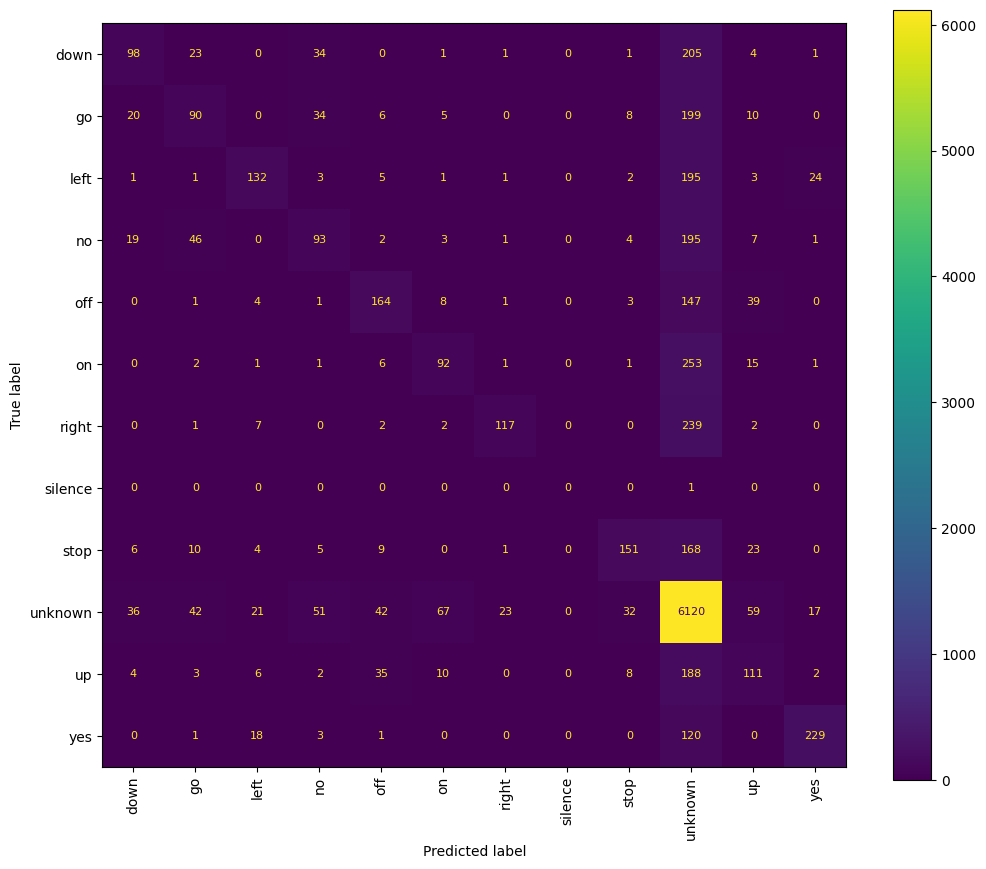

In [54]:
from sklearn import metrics
from matplotlib import pyplot as plt

predicted = K_N.predict(X_test)

print(metrics.classification_report(y_test, predicted, zero_division=0))

disp = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, 
    predicted, 
    text_kw={"fontsize": 8}
)

disp.figure_.set_size_inches(12, 10)

plt.setp(disp.ax_.get_xticklabels(), rotation=90)

plt.show()

### Visualization without silence and unknown labels

              precision    recall  f1-score   support

        down       0.53      0.27      0.36       368
          go       0.41      0.24      0.30       372
        left       0.68      0.36      0.47       368
          no       0.41      0.25      0.31       371
         off       0.60      0.45      0.51       368
          on       0.49      0.25      0.33       373
       right       0.80      0.32      0.45       370
        stop       0.72      0.40      0.51       377
          up       0.41      0.30      0.35       369
         yes       0.83      0.62      0.71       372

   micro avg       0.58      0.34      0.43      3708
   macro avg       0.59      0.34      0.43      3708
weighted avg       0.59      0.34      0.43      3708



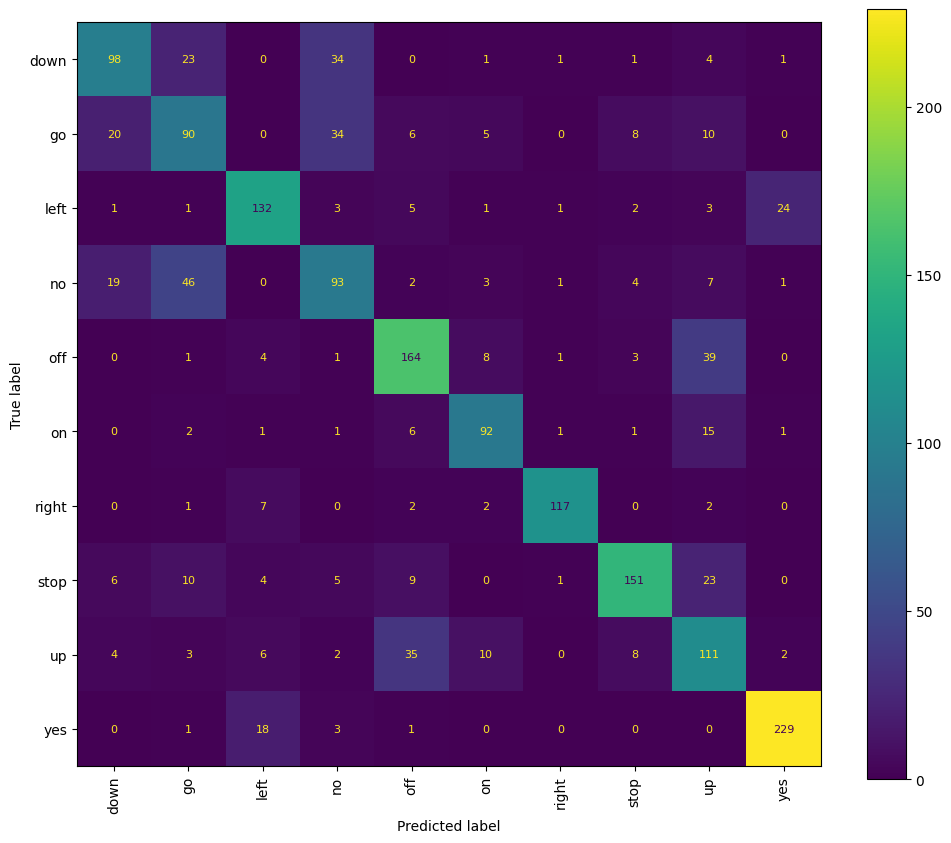

In [55]:
from sklearn import metrics
from matplotlib import pyplot as plt


exclude_labels = ['silence', 'unknown']

labels_to_include = [label for label in np.unique(y_test) if label not in exclude_labels]


print(metrics.classification_report(y_test, predicted, labels=labels_to_include, zero_division=0))


disp = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test,
    predicted,
    labels=labels_to_include,  
    text_kw={"fontsize": 8}
)


disp.figure_.set_size_inches(12, 10)
plt.setp(disp.ax_.get_xticklabels(), rotation=90)
plt.show()

### Cross validation verification

In [25]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(K_N, X_train, y_train, cv=5)
print(f"Cross-validation accuracy: {scores.mean():.2f} ± {scores.std():.2f}")

Cross-validation accuracy: 0.72 ± 0.01


# MLP Classifier

### Algorithm to select the best parameters in MLP

In [59]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

param_grid = {
    'hidden_layer_sizes': [(100,), (300,)],  
    'activation': ['relu', 'logistic'],      
    'solver': ['adam'],                      
    'alpha': [0.0001, 0.001],               
}

mlp = MLPClassifier(
    max_iter=1000,               
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10,
    random_state=69
)

grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)



Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (300,), 'solver': 'adam'}


### Training of the model and display of the metrics

              precision    recall  f1-score   support

        down       0.51      0.37      0.43       368
          go       0.42      0.26      0.32       372
        left       0.58      0.46      0.51       368
          no       0.45      0.36      0.40       371
         off       0.60      0.48      0.53       368
          on       0.52      0.39      0.45       373
       right       0.63      0.45      0.52       370
     silence       0.00      0.00      0.00         1
        stop       0.66      0.48      0.56       377
     unknown       0.80      0.91      0.85      6510
          up       0.43      0.40      0.41       369
         yes       0.81      0.68      0.74       372

    accuracy                           0.73     10219
   macro avg       0.53      0.44      0.48     10219
weighted avg       0.71      0.73      0.72     10219



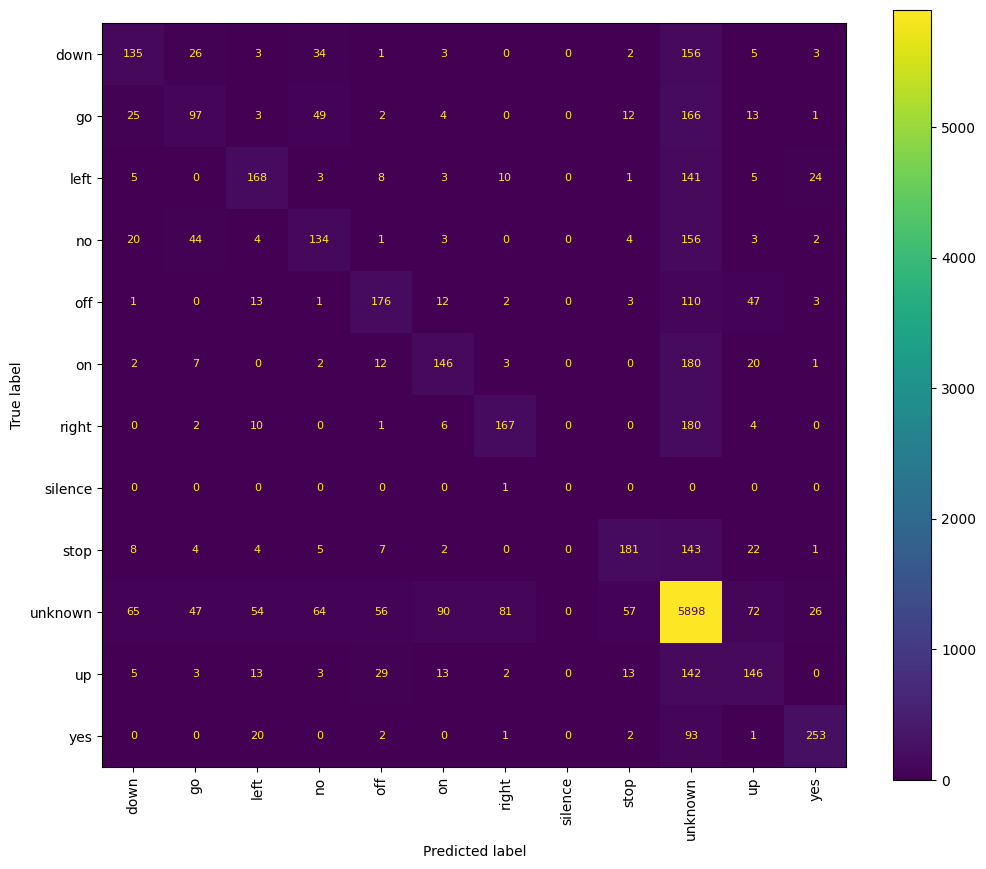

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mlp = MLPClassifier(
    hidden_layer_sizes=(300,),
    activation="relu",
    alpha=0.0001,
    solver="adam",
    max_iter=1000,
    random_state=43
)
mlp.fit(X_train, y_train)

predicted = mlp.predict(X_test)
print(metrics.classification_report(y_test, predicted, zero_division=0))

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted, text_kw={"fontsize": 8})
disp.figure_.set_size_inches(12, 10)
plt.setp(disp.ax_.get_xticklabels(), rotation=90)
plt.show()

### Visualization without silence and unknown labels

              precision    recall  f1-score   support

        down       0.51      0.37      0.43       368
          go       0.42      0.26      0.32       372
        left       0.58      0.46      0.51       368
          no       0.45      0.36      0.40       371
         off       0.60      0.48      0.53       368
          on       0.52      0.39      0.45       373
       right       0.63      0.45      0.52       370
        stop       0.66      0.48      0.56       377
          up       0.43      0.40      0.41       369
         yes       0.81      0.68      0.74       372

   micro avg       0.56      0.43      0.49      3708
   macro avg       0.56      0.43      0.49      3708
weighted avg       0.56      0.43      0.49      3708



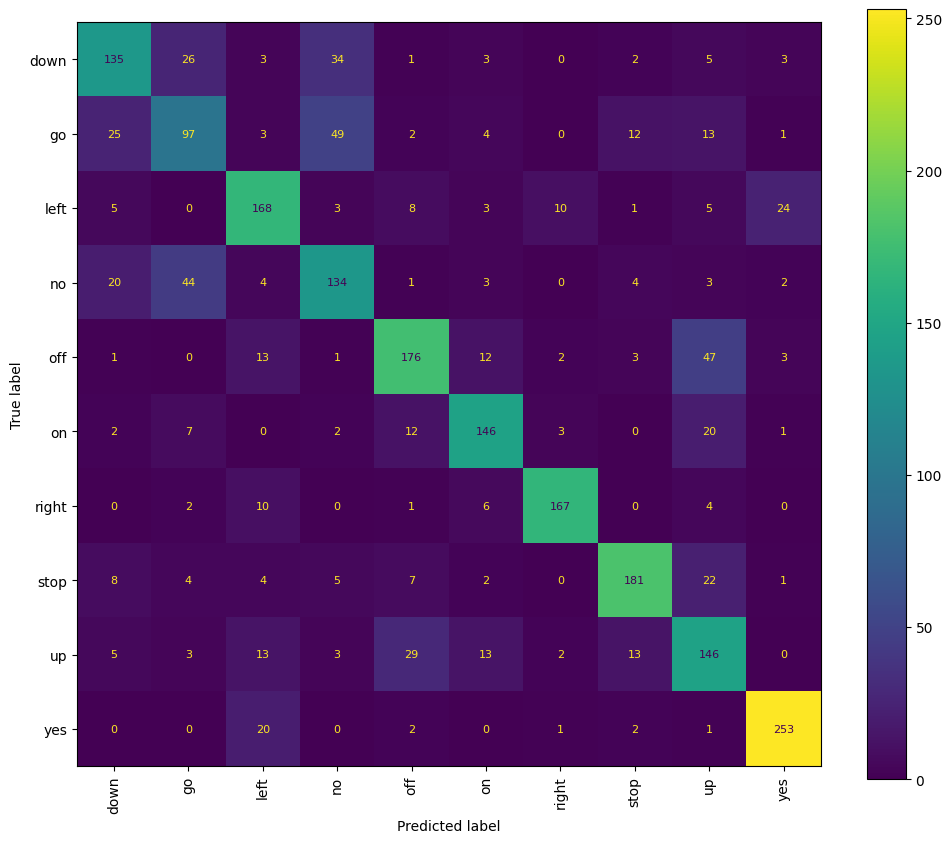

In [ ]:
from sklearn import metrics
from matplotlib import pyplot as plt


exclude_labels = ['silence', 'unknown']

labels_to_include = [label for label in np.unique(y_test) if label not in exclude_labels]

print(metrics.classification_report(y_test, predicted, labels=labels_to_include, zero_division=0))

disp = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test,
    predicted,
    labels=labels_to_include,  
    text_kw={"fontsize": 8}
)

disp.figure_.set_size_inches(12, 10)
plt.setp(disp.ax_.get_xticklabels(), rotation=90)
plt.show()

### Cross validation verification

In [62]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(mlp, X_train, y_train, cv=5)
print(f"Cross-validation accuracy: {scores.mean():.2f} ± {scores.std():.2f}")

Cross-validation accuracy: 0.72 ± 0.00
